In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

%matplotlib inline
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import pyodbc

server = 'tcp:190.27.1.13\BI' 
database = 'dbHighlife' 
username = 'srodriguez' 
password = 'Zmadgfv1' 
cnxn = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

In [9]:
QRY="""select c.hs_object_id, 
	   c.email,
       max(T.fecha_de_compra) Fecha_Max,
	   sum(T.po_total) as Importe,
	   count(distinct t.ticket) Frecuencia, 
       sum(T.po_total)/count(distinct t.ticket) as T_Prom,
	   DATEDIFF(dd,max(t.fecha_de_compra),getdate()) as Dias
from CRM_Contactos C join CRM_Tickets T on C.hs_object_id = T.id_contacto_asociado
where fecha_de_compra>='20200101'
and fecha_de_compra<=getdate()
and T.po_total>0

and C.email<>'' and email is not null
and t.ticket like 'PH%'
--and substring(ticket,2,4) not like '%[GSM]%'
group by c.hs_object_id, c.email

--having count(distinct t.ticket)<=20 and sum(T.po_total) >2
--having (sum(T.po_total)/count(distinct t.ticket)) <20000
"""


In [10]:
base = pd.read_sql(QRY,cnxn)

In [21]:
base

hs_object_id                  email   Fecha_Max   Importe  Frecuencia  \
0        66189657  _ocamon12@hotmail.com  2020-09-16   7423.28           1   
1       216899701       004609@sg.edi.mx  2021-10-13   2146.55           1   
2       208043201      0194378@up.edu.mx  2021-09-07   1805.17           1   
3       218042251   02105erick@gmail.com  2021-10-18   5423.28           1   
4       174533255      0236077@up.com.mx  2021-06-19    422.41           1   
...           ...                    ...         ...       ...         ...   
6427    101325986     zuqui007@gmail.com  2020-12-10   2230.17           1   
6428     79973132      zuralta@gmail.com  2020-10-22   3961.21           1   
6429    198695401   zurdoek669@gmail.com  2021-08-25  25516.37           3   
6430     77111704  zzepeda34@hotmail.com  2020-10-07   3786.21           1   
6431    159583201      zzrob64@gamil.com  2021-05-16   4236.20           1   

           T_Prom  Dias  F_class  R_class  
0     7423.280000   496      1.0      1.0  
1     2146.550000   104      1.0      4.0  
2     1805.170000   140      1.0      4.0  
3     5423.280000    99      1.0      4.0  
4      422.410000   220      1.0      3.0  
...           ...   ...      ...      ...  
6427  2230.170000   411      1.0      2.0  
6428  3961.210000   460      1.0      1.0  
6429  8505.456667   153      2.0      4.0  
6430  3786.210000   475      1.0      1.0  
6431  4236.200000   254      1.0      3.0  

[6432 rows x 9 columns]

In [12]:
FechaMax = base['Fecha_Max'].max()
print(FechaMax)

2022-01-24


In [13]:
base.quantile(np.linspace(0,1,6))

Importe  Frecuencia      T_Prom   Dias
0.0      76.720         1.0      76.720    1.0
0.2    1525.860         1.0    1307.872   90.0
0.4    2771.210         1.0    2309.468  187.0
0.6    4905.176         1.0    3845.687  302.0
0.8    9045.690         2.0    6886.380  433.0
1.0  202917.200        27.0  150988.790  752.0

In [14]:
lista_dias = base.quantile(np.linspace(0,1,6))['Dias'].to_list()
inter_dias= []
for x in range(0,5):
    inter_dias.append(list( ( lista_dias[x],lista_dias[x+1]) ) )
    
    
inter_dias.reverse()

inter_dias

[[433.0, 752.0], [302.0, 433.0], [187.0, 302.0], [90.0, 187.0], [1.0, 90.0]]

In [30]:
lista_imp = base.quantile(np.linspace(0,1,6))['Importe'].to_list()
inter_imp= []
for x in range(0,5):
    inter_imp.append(list( ( lista_imp[x],lista_imp[x+1]) ) )
    
inter_imp

[[76.72, 1525.86],
 [1525.86, 2769.83],
 [2769.83, 4905.174],
 [4905.174, 9045.742],
 [9045.742, 202917.2]]

In [47]:
lista_tprom = base.quantile(np.linspace(0,1,6))['T_Prom'].to_list()
inter_tprom= []
for x in range(0,5):
    inter_tprom.append(list( ( lista_tprom[x],lista_tprom[x+1]) ) )
    
inter_tprom

[[76.72, 1288.7933333333333],
 [1288.7933333333333, 2231.9],
 [2231.9, 3681.1766666666704],
 [3681.1766666666704, 6542.24],
 [6542.24, 19975.86]]

In [15]:
#ANALIZAR INTERVALOS DE TICKET PROMEDIO
# 
inter_man_tprom = list( ([0,2231.9],[2231.9, 3681.1766666666704],[3681.1766666666704, 6542.24],[6542.24, 19975.86],[19975.86,200000]) )

In [41]:
inter_man_tprom

[[0, 2231.9],
 [2231.9, 3681.1766666666704],
 [3681.1766666666704, 6542.24],
 [6542.24, 19975.86],
 [19975.86, 200000]]

In [31]:
#ANALIZAR
# Los intervalos son números enteros.
print(base.sort_values('Frecuencia')['Frecuencia'].unique().tolist())

print( len(base.sort_values('Frecuencia')['Frecuencia'].unique().tolist()) )

[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 19, 27]
15


In [16]:
inter_freq = list( ([1,2],[3,4],[5,6],[7,9],[11,27]) )

In [40]:
inter_freq

[[1, 2], [3, 4], [5, 6], [7, 9], [11, 27]]

In [17]:
for x,y in base.iterrows():
    for z in range(len(inter_freq)):
        if (y['Frecuencia']>=inter_freq[z][0] and y['Frecuencia']<= inter_freq[z][1]):
            print(y['Frecuencia'],inter_freq[z][0],inter_freq[z][1],z+1)
            base.loc[x,'F_class']=(z+1)

1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
3 3 4 2
3 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
4 3 4 2
2 1 2 1
2 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
2 1 2 1
2 1 2 1
1 1 2 1
2 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
3 3 4 2
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
2 1 2 1
7 7 9 4
1 1 2 1
4 3 4 2
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
5 5 6 3
1 1 2 1
1 1 2 1
2 1 2 1
2 1 2 1
1 1 2 1
2 1 2 1
2 1 2 1
1 1 2 1
5 5 6 3
3 3 4 2
1 1 2 1
3 3 4 2
1 1 2 1
2 1 2 1
3 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
4 3 4 2
3 3 4 2
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
2 1 2 1
3 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1


1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
4 3 4 2
1 1 2 1
3 3 4 2
2 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
2 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
4 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
2 1 2 1
1 1 2 1
2 1 2 1
15 11 27 5
1 1 2 1
2 1 2 1
1 1 2

1 1 2 1
7 7 9 4
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
2 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
4 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
2 1 2 1
2 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
2 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1


1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
4 3 4 2
1 1 2 1
2 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
3 3 4 2
3 3 4 2
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
3 3 4 2
2 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
2 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
4 3 4 2
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
3 3 4 2


1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
4 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
3 3 4 2
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
1 1 2 1
2 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
2 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
4 3 4 2
2 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
4 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
2 1 2 1
3 3 4 2
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
3 3 4 2
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
6 5 6 3


1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
2 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
3 3 4 2
1 1 2 1
3 3 4 2
1 1 2 1
2 1 2 1
2 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
5 5 6 3
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
2 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
4 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
5 5 6 3
1 1 2 1
3 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1


1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
2 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
4 3 4 2
1 1 2 1
1 1 2 1
4 3 4 2
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
2 1 2 1
2 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
1 1 2 1
1 1 2 1
2 1 2 1
1 1 2 1
1 1 2 1
3 3 4 2
1 1 2 1
1 1 2 1


In [18]:
for x,y in base.iterrows():
    for z in range(len(inter_dias)):
        if (y['Dias']>=inter_dias[z][0] and y['Dias']<= inter_dias[z][1]):
            print(y['Dias'],inter_dias[z][0],inter_dias[z][1],z+1)
            base.loc[x,'R_class']=(z+1)

496 433.0 752.0 1
104 90.0 187.0 4
140 90.0 187.0 4
99 90.0 187.0 4
220 187.0 302.0 3
298 187.0 302.0 3
227 187.0 302.0 3
436 433.0 752.0 1
261 187.0 302.0 3
723 433.0 752.0 1
55 1.0 90.0 5
512 433.0 752.0 1
317 302.0 433.0 2
304 302.0 433.0 2
313 302.0 433.0 2
90 90.0 187.0 4
90 1.0 90.0 5
444 433.0 752.0 1
205 187.0 302.0 3
344 302.0 433.0 2
471 433.0 752.0 1
171 90.0 187.0 4
23 1.0 90.0 5
71 1.0 90.0 5
113 90.0 187.0 4
237 187.0 302.0 3
196 187.0 302.0 3
504 433.0 752.0 1
150 90.0 187.0 4
446 433.0 752.0 1
86 1.0 90.0 5
408 302.0 433.0 2
264 187.0 302.0 3
107 90.0 187.0 4
178 90.0 187.0 4
159 90.0 187.0 4
146 90.0 187.0 4
42 1.0 90.0 5
191 187.0 302.0 3
209 187.0 302.0 3
193 187.0 302.0 3
253 187.0 302.0 3
60 1.0 90.0 5
304 302.0 433.0 2
356 302.0 433.0 2
358 302.0 433.0 2
248 187.0 302.0 3
438 433.0 752.0 1
513 433.0 752.0 1
270 187.0 302.0 3
110 90.0 187.0 4
110 90.0 187.0 4
443 433.0 752.0 1
406 302.0 433.0 2
81 1.0 90.0 5
514 433.0 752.0 1
66 1.0 90.0 5
163 90.0 187.0 4
513 433.

131 90.0 187.0 4
445 433.0 752.0 1
269 187.0 302.0 3
393 302.0 433.0 2
116 90.0 187.0 4
81 1.0 90.0 5
164 90.0 187.0 4
330 302.0 433.0 2
52 1.0 90.0 5
73 1.0 90.0 5
45 1.0 90.0 5
720 433.0 752.0 1
316 302.0 433.0 2
269 187.0 302.0 3
80 1.0 90.0 5
268 187.0 302.0 3
274 187.0 302.0 3
129 90.0 187.0 4
252 187.0 302.0 3
44 1.0 90.0 5
263 187.0 302.0 3
417 302.0 433.0 2
525 433.0 752.0 1
79 1.0 90.0 5
465 433.0 752.0 1
100 90.0 187.0 4
481 433.0 752.0 1
165 90.0 187.0 4
72 1.0 90.0 5
28 1.0 90.0 5
303 302.0 433.0 2
192 187.0 302.0 3
335 302.0 433.0 2
448 433.0 752.0 1
450 433.0 752.0 1
410 302.0 433.0 2
214 187.0 302.0 3
161 90.0 187.0 4
79 1.0 90.0 5
479 433.0 752.0 1
500 433.0 752.0 1
268 187.0 302.0 3
170 90.0 187.0 4
455 433.0 752.0 1
64 1.0 90.0 5
47 1.0 90.0 5
130 90.0 187.0 4
74 1.0 90.0 5
481 433.0 752.0 1
514 433.0 752.0 1
45 1.0 90.0 5
372 302.0 433.0 2
55 1.0 90.0 5
114 90.0 187.0 4
305 302.0 433.0 2
303 302.0 433.0 2
439 433.0 752.0 1
326 302.0 433.0 2
41 1.0 90.0 5
165 90.0 187

301 187.0 302.0 3
420 302.0 433.0 2
9 1.0 90.0 5
514 433.0 752.0 1
442 433.0 752.0 1
192 187.0 302.0 3
449 433.0 752.0 1
466 433.0 752.0 1
295 187.0 302.0 3
485 433.0 752.0 1
446 433.0 752.0 1
510 433.0 752.0 1
107 90.0 187.0 4
31 1.0 90.0 5
438 433.0 752.0 1
304 302.0 433.0 2
143 90.0 187.0 4
269 187.0 302.0 3
82 1.0 90.0 5
185 90.0 187.0 4
370 302.0 433.0 2
310 302.0 433.0 2
499 433.0 752.0 1
226 187.0 302.0 3
255 187.0 302.0 3
428 302.0 433.0 2
435 433.0 752.0 1
181 90.0 187.0 4
215 187.0 302.0 3
460 433.0 752.0 1
438 433.0 752.0 1
46 1.0 90.0 5
3 1.0 90.0 5
717 433.0 752.0 1
185 90.0 187.0 4
84 1.0 90.0 5
82 1.0 90.0 5
134 90.0 187.0 4
134 90.0 187.0 4
316 302.0 433.0 2
297 187.0 302.0 3
442 433.0 752.0 1
508 433.0 752.0 1
324 302.0 433.0 2
197 187.0 302.0 3
135 90.0 187.0 4
163 90.0 187.0 4
149 90.0 187.0 4
125 90.0 187.0 4
305 302.0 433.0 2
88 1.0 90.0 5
278 187.0 302.0 3
212 187.0 302.0 3
246 187.0 302.0 3
415 302.0 433.0 2
272 187.0 302.0 3
220 187.0 302.0 3
339 302.0 433.0 2
1

341 302.0 433.0 2
397 302.0 433.0 2
96 90.0 187.0 4
240 187.0 302.0 3
201 187.0 302.0 3
433 433.0 752.0 1
433 302.0 433.0 2
333 302.0 433.0 2
72 1.0 90.0 5
73 1.0 90.0 5
43 1.0 90.0 5
166 90.0 187.0 4
325 302.0 433.0 2
237 187.0 302.0 3
209 187.0 302.0 3
449 433.0 752.0 1
464 433.0 752.0 1
72 1.0 90.0 5
95 90.0 187.0 4
233 187.0 302.0 3
719 433.0 752.0 1
324 302.0 433.0 2
284 187.0 302.0 3
199 187.0 302.0 3
27 1.0 90.0 5
435 433.0 752.0 1
115 90.0 187.0 4
330 302.0 433.0 2
305 302.0 433.0 2
481 433.0 752.0 1
421 302.0 433.0 2
424 302.0 433.0 2
156 90.0 187.0 4
114 90.0 187.0 4
52 1.0 90.0 5
23 1.0 90.0 5
263 187.0 302.0 3
181 90.0 187.0 4
422 302.0 433.0 2
522 433.0 752.0 1
485 433.0 752.0 1
85 1.0 90.0 5
60 1.0 90.0 5
428 302.0 433.0 2
417 302.0 433.0 2
140 90.0 187.0 4
74 1.0 90.0 5
192 187.0 302.0 3
74 1.0 90.0 5
42 1.0 90.0 5
227 187.0 302.0 3
49 1.0 90.0 5
205 187.0 302.0 3
261 187.0 302.0 3
416 302.0 433.0 2
171 90.0 187.0 4
349 302.0 433.0 2
478 433.0 752.0 1
108 90.0 187.0 4
68

116 90.0 187.0 4
102 90.0 187.0 4
514 433.0 752.0 1
245 187.0 302.0 3
421 302.0 433.0 2
164 90.0 187.0 4
86 1.0 90.0 5
58 1.0 90.0 5
73 1.0 90.0 5
1 1.0 90.0 5
422 302.0 433.0 2
404 302.0 433.0 2
205 187.0 302.0 3
472 433.0 752.0 1
184 90.0 187.0 4
171 90.0 187.0 4
104 90.0 187.0 4
152 90.0 187.0 4
134 90.0 187.0 4
67 1.0 90.0 5
338 302.0 433.0 2
456 433.0 752.0 1
52 1.0 90.0 5
235 187.0 302.0 3
140 90.0 187.0 4
108 90.0 187.0 4
342 302.0 433.0 2
66 1.0 90.0 5
228 187.0 302.0 3
336 302.0 433.0 2
115 90.0 187.0 4
465 433.0 752.0 1
182 90.0 187.0 4
409 302.0 433.0 2
70 1.0 90.0 5
128 90.0 187.0 4
414 302.0 433.0 2
71 1.0 90.0 5
162 90.0 187.0 4
470 433.0 752.0 1
503 433.0 752.0 1
420 302.0 433.0 2
80 1.0 90.0 5
51 1.0 90.0 5
50 1.0 90.0 5
316 302.0 433.0 2
441 433.0 752.0 1
79 1.0 90.0 5
400 302.0 433.0 2
45 1.0 90.0 5
72 1.0 90.0 5
71 1.0 90.0 5
66 1.0 90.0 5
311 302.0 433.0 2
320 302.0 433.0 2
511 433.0 752.0 1
582 433.0 752.0 1
304 302.0 433.0 2
116 90.0 187.0 4
263 187.0 302.0 3
525 

453 433.0 752.0 1
458 433.0 752.0 1
325 302.0 433.0 2
462 433.0 752.0 1
477 433.0 752.0 1
46 1.0 90.0 5
349 302.0 433.0 2
114 90.0 187.0 4
286 187.0 302.0 3
55 1.0 90.0 5
110 90.0 187.0 4
199 187.0 302.0 3
81 1.0 90.0 5
146 90.0 187.0 4
80 1.0 90.0 5
311 302.0 433.0 2
493 433.0 752.0 1
339 302.0 433.0 2
122 90.0 187.0 4
415 302.0 433.0 2
370 302.0 433.0 2
434 433.0 752.0 1
43 1.0 90.0 5
43 1.0 90.0 5
221 187.0 302.0 3
431 302.0 433.0 2
184 90.0 187.0 4
435 433.0 752.0 1
358 302.0 433.0 2
329 302.0 433.0 2
90 90.0 187.0 4
90 1.0 90.0 5
698 433.0 752.0 1
361 302.0 433.0 2
153 90.0 187.0 4
211 187.0 302.0 3
315 302.0 433.0 2
191 187.0 302.0 3
44 1.0 90.0 5
234 187.0 302.0 3
106 90.0 187.0 4
199 187.0 302.0 3
483 433.0 752.0 1
344 302.0 433.0 2
323 302.0 433.0 2
378 302.0 433.0 2
150 90.0 187.0 4
513 433.0 752.0 1
93 90.0 187.0 4
517 433.0 752.0 1
303 302.0 433.0 2
92 90.0 187.0 4
304 302.0 433.0 2
288 187.0 302.0 3
436 433.0 752.0 1
226 187.0 302.0 3
226 187.0 302.0 3
408 302.0 433.0 2
45

84 1.0 90.0 5
270 187.0 302.0 3
206 187.0 302.0 3
38 1.0 90.0 5
275 187.0 302.0 3
184 90.0 187.0 4
269 187.0 302.0 3
265 187.0 302.0 3
268 187.0 302.0 3
213 187.0 302.0 3
323 302.0 433.0 2
121 90.0 187.0 4
430 302.0 433.0 2
710 433.0 752.0 1
328 302.0 433.0 2
269 187.0 302.0 3
511 433.0 752.0 1
513 433.0 752.0 1
475 433.0 752.0 1
87 1.0 90.0 5
291 187.0 302.0 3
172 90.0 187.0 4
79 1.0 90.0 5
268 187.0 302.0 3
406 302.0 433.0 2
456 433.0 752.0 1
581 433.0 752.0 1
298 187.0 302.0 3
222 187.0 302.0 3
407 302.0 433.0 2
245 187.0 302.0 3
72 1.0 90.0 5
321 302.0 433.0 2
159 90.0 187.0 4
269 187.0 302.0 3
447 433.0 752.0 1
2 1.0 90.0 5
200 187.0 302.0 3
386 302.0 433.0 2
431 302.0 433.0 2
116 90.0 187.0 4
297 187.0 302.0 3
233 187.0 302.0 3
73 1.0 90.0 5
77 1.0 90.0 5
465 433.0 752.0 1
346 302.0 433.0 2
521 433.0 752.0 1
438 433.0 752.0 1
337 302.0 433.0 2
470 433.0 752.0 1
523 433.0 752.0 1
65 1.0 90.0 5
87 1.0 90.0 5
455 433.0 752.0 1
427 302.0 433.0 2
192 187.0 302.0 3
60 1.0 90.0 5
430 30

272 187.0 302.0 3
220 187.0 302.0 3
175 90.0 187.0 4
317 302.0 433.0 2
87 1.0 90.0 5
474 433.0 752.0 1
469 433.0 752.0 1
223 187.0 302.0 3
22 1.0 90.0 5
417 302.0 433.0 2
320 302.0 433.0 2
486 433.0 752.0 1
102 90.0 187.0 4
723 433.0 752.0 1
111 90.0 187.0 4
420 302.0 433.0 2
151 90.0 187.0 4
106 90.0 187.0 4
214 187.0 302.0 3
84 1.0 90.0 5
414 302.0 433.0 2
508 433.0 752.0 1
160 90.0 187.0 4
227 187.0 302.0 3
47 1.0 90.0 5
96 90.0 187.0 4
350 302.0 433.0 2
191 187.0 302.0 3
50 1.0 90.0 5
298 187.0 302.0 3
418 302.0 433.0 2
435 433.0 752.0 1
457 433.0 752.0 1
240 187.0 302.0 3
71 1.0 90.0 5
330 302.0 433.0 2
269 187.0 302.0 3
374 302.0 433.0 2
166 90.0 187.0 4
463 433.0 752.0 1
150 90.0 187.0 4
444 433.0 752.0 1
45 1.0 90.0 5
50 1.0 90.0 5
131 90.0 187.0 4
513 433.0 752.0 1
91 90.0 187.0 4
459 433.0 752.0 1
228 187.0 302.0 3
411 302.0 433.0 2
194 187.0 302.0 3
30 1.0 90.0 5
157 90.0 187.0 4
365 302.0 433.0 2
83 1.0 90.0 5
187 187.0 302.0 3
187 90.0 187.0 4
240 187.0 302.0 3
223 187.0 3

514 433.0 752.0 1
508 433.0 752.0 1
223 187.0 302.0 3
348 302.0 433.0 2
348 302.0 433.0 2
430 302.0 433.0 2
324 302.0 433.0 2
73 1.0 90.0 5
216 187.0 302.0 3
233 187.0 302.0 3
63 1.0 90.0 5
413 302.0 433.0 2
321 302.0 433.0 2
112 90.0 187.0 4
448 433.0 752.0 1
269 187.0 302.0 3
101 90.0 187.0 4
160 90.0 187.0 4
363 302.0 433.0 2
65 1.0 90.0 5
187 187.0 302.0 3
187 90.0 187.0 4
32 1.0 90.0 5
118 90.0 187.0 4
429 302.0 433.0 2
172 90.0 187.0 4
92 90.0 187.0 4
79 1.0 90.0 5
60 1.0 90.0 5
179 90.0 187.0 4
213 187.0 302.0 3
79 1.0 90.0 5
361 302.0 433.0 2
84 1.0 90.0 5
288 187.0 302.0 3
100 90.0 187.0 4
82 1.0 90.0 5
259 187.0 302.0 3
60 1.0 90.0 5
341 302.0 433.0 2
303 302.0 433.0 2
58 1.0 90.0 5
221 187.0 302.0 3
449 433.0 752.0 1
315 302.0 433.0 2
306 302.0 433.0 2
42 1.0 90.0 5
160 90.0 187.0 4
216 187.0 302.0 3
52 1.0 90.0 5
335 302.0 433.0 2
307 302.0 433.0 2
298 187.0 302.0 3
507 433.0 752.0 1
480 433.0 752.0 1
406 302.0 433.0 2
205 187.0 302.0 3
315 302.0 433.0 2
40 1.0 90.0 5
71 1.

430 302.0 433.0 2
121 90.0 187.0 4
196 187.0 302.0 3
136 90.0 187.0 4
436 433.0 752.0 1
142 90.0 187.0 4
106 90.0 187.0 4
347 302.0 433.0 2
255 187.0 302.0 3
511 433.0 752.0 1
47 1.0 90.0 5
275 187.0 302.0 3
219 187.0 302.0 3
431 302.0 433.0 2
331 302.0 433.0 2
217 187.0 302.0 3
176 90.0 187.0 4
340 302.0 433.0 2
128 90.0 187.0 4
147 90.0 187.0 4
341 302.0 433.0 2
435 433.0 752.0 1
412 302.0 433.0 2
299 187.0 302.0 3
294 187.0 302.0 3
693 433.0 752.0 1
227 187.0 302.0 3
309 302.0 433.0 2
102 90.0 187.0 4
490 433.0 752.0 1
143 90.0 187.0 4
238 187.0 302.0 3
427 302.0 433.0 2
158 90.0 187.0 4
287 187.0 302.0 3
226 187.0 302.0 3
86 1.0 90.0 5
463 433.0 752.0 1
62 1.0 90.0 5
428 302.0 433.0 2
228 187.0 302.0 3
305 302.0 433.0 2
227 187.0 302.0 3
233 187.0 302.0 3
224 187.0 302.0 3
93 90.0 187.0 4
51 1.0 90.0 5
213 187.0 302.0 3
434 433.0 752.0 1
9 1.0 90.0 5
310 302.0 433.0 2
299 187.0 302.0 3
95 90.0 187.0 4
105 90.0 187.0 4
266 187.0 302.0 3
228 187.0 302.0 3
471 433.0 752.0 1
206 187.0 

167 90.0 187.0 4
481 433.0 752.0 1
743 433.0 752.0 1
101 90.0 187.0 4
450 433.0 752.0 1
87 1.0 90.0 5
441 433.0 752.0 1
420 302.0 433.0 2
94 90.0 187.0 4
70 1.0 90.0 5
500 433.0 752.0 1
124 90.0 187.0 4
84 1.0 90.0 5
30 1.0 90.0 5
203 187.0 302.0 3
310 302.0 433.0 2
316 302.0 433.0 2
237 187.0 302.0 3
323 302.0 433.0 2
455 433.0 752.0 1
465 433.0 752.0 1
138 90.0 187.0 4
41 1.0 90.0 5
508 433.0 752.0 1
72 1.0 90.0 5
427 302.0 433.0 2
185 90.0 187.0 4
58 1.0 90.0 5
520 433.0 752.0 1
464 433.0 752.0 1
198 187.0 302.0 3
200 187.0 302.0 3
431 302.0 433.0 2
37 1.0 90.0 5
72 1.0 90.0 5
160 90.0 187.0 4
235 187.0 302.0 3
201 187.0 302.0 3
262 187.0 302.0 3
309 302.0 433.0 2
222 187.0 302.0 3
222 187.0 302.0 3
460 433.0 752.0 1
97 90.0 187.0 4
733 433.0 752.0 1
159 90.0 187.0 4
533 433.0 752.0 1
98 90.0 187.0 4
456 433.0 752.0 1
44 1.0 90.0 5
206 187.0 302.0 3
45 1.0 90.0 5
122 90.0 187.0 4
118 90.0 187.0 4
66 1.0 90.0 5
232 187.0 302.0 3
23 1.0 90.0 5
431 302.0 433.0 2
71 1.0 90.0 5
156 90.0 

74 1.0 90.0 5
445 433.0 752.0 1
276 187.0 302.0 3
741 433.0 752.0 1
170 90.0 187.0 4
114 90.0 187.0 4
445 433.0 752.0 1
393 302.0 433.0 2
54 1.0 90.0 5
53 1.0 90.0 5
306 302.0 433.0 2
2 1.0 90.0 5
432 302.0 433.0 2
169 90.0 187.0 4
74 1.0 90.0 5
214 187.0 302.0 3
175 90.0 187.0 4
440 433.0 752.0 1
78 1.0 90.0 5
324 302.0 433.0 2
338 302.0 433.0 2
504 433.0 752.0 1
246 187.0 302.0 3
358 302.0 433.0 2
135 90.0 187.0 4
403 302.0 433.0 2
415 302.0 433.0 2
678 433.0 752.0 1
93 90.0 187.0 4
41 1.0 90.0 5
68 1.0 90.0 5
441 433.0 752.0 1
437 433.0 752.0 1
324 302.0 433.0 2
436 433.0 752.0 1
343 302.0 433.0 2
317 302.0 433.0 2
318 302.0 433.0 2
318 302.0 433.0 2
349 302.0 433.0 2
236 187.0 302.0 3
704 433.0 752.0 1
449 433.0 752.0 1
318 302.0 433.0 2
134 90.0 187.0 4
241 187.0 302.0 3
45 1.0 90.0 5
143 90.0 187.0 4
252 187.0 302.0 3
76 1.0 90.0 5
4 1.0 90.0 5
466 433.0 752.0 1
517 433.0 752.0 1
416 302.0 433.0 2
183 90.0 187.0 4
443 433.0 752.0 1
220 187.0 302.0 3
226 187.0 302.0 3
472 433.0 75

457 433.0 752.0 1
306 302.0 433.0 2
444 433.0 752.0 1
45 1.0 90.0 5
46 1.0 90.0 5
177 90.0 187.0 4
437 433.0 752.0 1
436 433.0 752.0 1
42 1.0 90.0 5
67 1.0 90.0 5
79 1.0 90.0 5
75 1.0 90.0 5
213 187.0 302.0 3
65 1.0 90.0 5
124 90.0 187.0 4
114 90.0 187.0 4
131 90.0 187.0 4
5 1.0 90.0 5
325 302.0 433.0 2
112 90.0 187.0 4
439 433.0 752.0 1
222 187.0 302.0 3
69 1.0 90.0 5
71 1.0 90.0 5
43 1.0 90.0 5
448 433.0 752.0 1
172 90.0 187.0 4
238 187.0 302.0 3
487 433.0 752.0 1
433 433.0 752.0 1
433 302.0 433.0 2
212 187.0 302.0 3
41 1.0 90.0 5
128 90.0 187.0 4
513 433.0 752.0 1
322 302.0 433.0 2
132 90.0 187.0 4
433 433.0 752.0 1
433 302.0 433.0 2
517 433.0 752.0 1
284 187.0 302.0 3
159 90.0 187.0 4
52 1.0 90.0 5
143 90.0 187.0 4
481 433.0 752.0 1
318 302.0 433.0 2
41 1.0 90.0 5
65 1.0 90.0 5
176 90.0 187.0 4
45 1.0 90.0 5
345 302.0 433.0 2
165 90.0 187.0 4
323 302.0 433.0 2
73 1.0 90.0 5
434 433.0 752.0 1
59 1.0 90.0 5
388 302.0 433.0 2
213 187.0 302.0 3
311 302.0 433.0 2
407 302.0 433.0 2
71 1.

In [35]:
for x,y in base.iterrows():
    for z in range(len(inter_imp)):
        if (y['Importe']>=inter_imp[z][0] and y['Importe']<= inter_imp[z][1]):
            print(y['Importe'],inter_imp[z][0],inter_imp[z][1],z+1)
            base.loc[x,'M_class']=(z+1)

7423.28 4905.174 9045.742 4
2146.55 1525.86 2769.83 2
1805.17 1525.86 2769.83 2
5423.28 4905.174 9045.742 4
422.41 76.72 1525.86 1
2150.86 1525.86 2769.83 2
4112.07 2769.83 4905.174 3
15165.52 9045.742 202917.2 5
3138.78 2769.83 4905.174 3
13853.44 9045.742 202917.2 5
10773.27 9045.742 202917.2 5
5425.0 4905.174 9045.742 4
1112.07 76.72 1525.86 1
5168.1 4905.174 9045.742 4
1543.1 1525.86 2769.83 2
2663.79 1525.86 2769.83 2
23621.55 9045.742 202917.2 5
10649.13 9045.742 202917.2 5
3094.83 2769.83 4905.174 3
2407.77 1525.86 2769.83 2
814.65 76.72 1525.86 1
13875.0 9045.742 202917.2 5
2396.55 1525.86 2769.83 2
5318.1 4905.174 9045.742 4
1112.07 76.72 1525.86 1
12474.14 9045.742 202917.2 5
1292.24 76.72 1525.86 1
1284.48 76.72 1525.86 1
8568.96 4905.174 9045.742 4
9780.16 9045.742 202917.2 5
13550.0 9045.742 202917.2 5
594.83 76.72 1525.86 1
13227.55 9045.742 202917.2 5
6801.72 4905.174 9045.742 4
4200.01 2769.83 4905.174 3
11198.28 9045.742 202917.2 5
2224.14 1525.86 2769.83 2
1275.86 76.

1344.82 76.72 1525.86 1
2396.55 1525.86 2769.83 2
2749.15 1525.86 2769.83 2
6250.0 4905.174 9045.742 4
10947.41 9045.742 202917.2 5
5924.14 4905.174 9045.742 4
2366.38 1525.86 2769.83 2
853.45 76.72 1525.86 1
2836.21 2769.83 4905.174 3
4801.72 2769.83 4905.174 3
14550.86 9045.742 202917.2 5
3436.2 2769.83 4905.174 3
2152.59 1525.86 2769.83 2
3086.21 2769.83 4905.174 3
4353.44 2769.83 4905.174 3
24627.57 9045.742 202917.2 5
3400.86 2769.83 4905.174 3
10808.62 9045.742 202917.2 5
5797.41 4905.174 9045.742 4
27019.0 9045.742 202917.2 5
1543.1 1525.86 2769.83 2
49539.66 9045.742 202917.2 5
681.04 76.72 1525.86 1
3956.9 2769.83 4905.174 3
586.2 76.72 1525.86 1
3988.79 2769.83 4905.174 3
2913.8 2769.83 4905.174 3
9258.62 9045.742 202917.2 5
771.55 76.72 1525.86 1
2407.77 1525.86 2769.83 2
29800.0 9045.742 202917.2 5
11202.57 9045.742 202917.2 5
7401.72 4905.174 9045.742 4
10902.75 9045.742 202917.2 5
19598.28 9045.742 202917.2 5
15015.52 9045.742 202917.2 5
17331.87 9045.742 202917.2 5
2146.

14801.72 9045.742 202917.2 5
3163.79 2769.83 4905.174 3
6030.16 4905.174 9045.742 4
1698.28 1525.86 2769.83 2
34304.31 9045.742 202917.2 5
5423.28 4905.174 9045.742 4
2934.49 2769.83 4905.174 3
1388.79 76.72 1525.86 1
6422.42 4905.174 9045.742 4
1993.1 1525.86 2769.83 2
2962.07 2769.83 4905.174 3
12920.26 9045.742 202917.2 5
1723.28 1525.86 2769.83 2
1479.31 76.72 1525.86 1
8586.2 4905.174 9045.742 4
2401.72 1525.86 2769.83 2
1628.45 1525.86 2769.83 2
6056.03 4905.174 9045.742 4
3016.38 2769.83 4905.174 3
4218.1 2769.83 4905.174 3
11023.71 9045.742 202917.2 5
646.12 76.72 1525.86 1
4124.99 2769.83 4905.174 3
12734.48 9045.742 202917.2 5
2491.38 1525.86 2769.83 2
5720.69 4905.174 9045.742 4
171.55 76.72 1525.86 1
5301.71 4905.174 9045.742 4
6025.86 4905.174 9045.742 4
1377.59 76.72 1525.86 1
767.24 76.72 1525.86 1
3745.69 2769.83 4905.174 3
1284.48 76.72 1525.86 1
2178.45 1525.86 2769.83 2
681.03 76.72 1525.86 1
594.83 76.72 1525.86 1
2407.76 1525.86 2769.83 2
9825.86 9045.742 202917.2 

6560.77 4905.174 9045.742 4
2168.11 1525.86 2769.83 2
3438.79 2769.83 4905.174 3
4849.12 2769.83 4905.174 3
13603.45 9045.742 202917.2 5
1391.39 76.72 1525.86 1
6801.72 4905.174 9045.742 4
771.55 76.72 1525.86 1
1504.31 76.72 1525.86 1
1543.1 1525.86 2769.83 2
2146.55 1525.86 2769.83 2
7448.28 4905.174 9045.742 4
1019.83 76.72 1525.86 1
2748.28 1525.86 2769.83 2
1353.45 76.72 1525.86 1
1284.48 76.72 1525.86 1
1543.1 1525.86 2769.83 2
9186.21 9045.742 202917.2 5
7991.38 4905.174 9045.742 4
2407.77 1525.86 2769.83 2
1112.07 76.72 1525.86 1
10787.92 9045.742 202917.2 5
4732.76 2769.83 4905.174 3
4879.29 2769.83 4905.174 3
857.76 76.72 1525.86 1
12865.51 9045.742 202917.2 5
2595.69 1525.86 2769.83 2
469.83 76.72 1525.86 1
681.03 76.72 1525.86 1
594.83 76.72 1525.86 1
7316.38 4905.174 9045.742 4
3352.58 2769.83 4905.174 3
3718.96 2769.83 4905.174 3
1456.9 76.72 1525.86 1
10060.35 9045.742 202917.2 5
1284.48 76.72 1525.86 1
9651.72 9045.742 202917.2 5
1543.1 1525.86 2769.83 2
12051.72 9045.7

3482.77 2769.83 4905.174 3
5767.24 4905.174 9045.742 4
3171.55 2769.83 4905.174 3
1284.48 76.72 1525.86 1
16712.92 9045.742 202917.2 5
1275.86 76.72 1525.86 1
1706.89 1525.86 2769.83 2
1234.48 76.72 1525.86 1
5358.62 4905.174 9045.742 4
1706.9 1525.86 2769.83 2
27594.83 9045.742 202917.2 5
7515.52 4905.174 9045.742 4
7227.59 4905.174 9045.742 4
8881.9 4905.174 9045.742 4
1439.65 76.72 1525.86 1
2178.45 1525.86 2769.83 2
4554.31 2769.83 4905.174 3
1543.1 1525.86 2769.83 2
4043.1 2769.83 4905.174 3
26992.24 9045.742 202917.2 5
1623.28 1525.86 2769.83 2
1517.24 76.72 1525.86 1
1543.1 1525.86 2769.83 2
508.62 76.72 1525.86 1
11831.06 9045.742 202917.2 5
1000.86 76.72 1525.86 1
2350.86 1525.86 2769.83 2
8564.65 4905.174 9045.742 4
5163.79 4905.174 9045.742 4
6819.83 4905.174 9045.742 4
4857.78 2769.83 4905.174 3
681.04 76.72 1525.86 1
3955.17 2769.83 4905.174 3
23693.1 9045.742 202917.2 5
8694.48 4905.174 9045.742 4
3960.34 2769.83 4905.174 3
5683.62 4905.174 9045.742 4
4123.27 2769.83 4905

5586.21 4905.174 9045.742 4
2146.83 1525.86 2769.83 2
10837.08 9045.742 202917.2 5
10336.21 9045.742 202917.2 5
8436.21 4905.174 9045.742 4
1198.28 76.72 1525.86 1
21687.92 9045.742 202917.2 5
7567.24 4905.174 9045.742 4
26510.35 9045.742 202917.2 5
1341.38 76.72 1525.86 1
3011.21 2769.83 4905.174 3
5690.52 4905.174 9045.742 4
6969.83 4905.174 9045.742 4
6849.14 4905.174 9045.742 4
3162.07 2769.83 4905.174 3
2485.34 1525.86 2769.83 2
1362.06 76.72 1525.86 1
2146.55 1525.86 2769.83 2
3400.86 2769.83 4905.174 3
3016.03 2769.83 4905.174 3
3125.86 2769.83 4905.174 3
6160.34 4905.174 9045.742 4
5155.18 4905.174 9045.742 4
37856.9 9045.742 202917.2 5
6762.93 4905.174 9045.742 4
687.94 76.72 1525.86 1
6879.31 4905.174 9045.742 4
3016.04 2769.83 4905.174 3
6362.07 4905.174 9045.742 4
3801.71 2769.83 4905.174 3
775.0 76.72 1525.86 1
2588.79 1525.86 2769.83 2
1391.39 76.72 1525.86 1
1965.52 1525.86 2769.83 2
4030.17 2769.83 4905.174 3
6025.86 4905.174 9045.742 4
2838.27 2769.83 4905.174 3
594.83

9168.98 9045.742 202917.2 5
1793.1 1525.86 2769.83 2
3060.35 2769.83 4905.174 3
1892.24 1525.86 2769.83 2
12087.93 9045.742 202917.2 5
6801.72 4905.174 9045.742 4
1853.44 1525.86 2769.83 2
5810.35 4905.174 9045.742 4
4017.22 2769.83 4905.174 3
3180.17 2769.83 4905.174 3
1197.42 76.72 1525.86 1
25584.48 9045.742 202917.2 5
422.41 76.72 1525.86 1
5142.23 4905.174 9045.742 4
1189.65 76.72 1525.86 1
16370.69 9045.742 202917.2 5
999.99 76.72 1525.86 1
2237.07 1525.86 2769.83 2
3507.76 2769.83 4905.174 3
12062.93 9045.742 202917.2 5
5491.38 4905.174 9045.742 4
2991.37 2769.83 4905.174 3
11198.28 9045.742 202917.2 5
2533.97 1525.86 2769.83 2
1112.07 76.72 1525.86 1
1073.28 76.72 1525.86 1
3862.07 2769.83 4905.174 3
5144.86 4905.174 9045.742 4
2034.48 1525.86 2769.83 2
13784.48 9045.742 202917.2 5
14985.34 9045.742 202917.2 5
9612.07 9045.742 202917.2 5
1623.29 1525.86 2769.83 2
1460.95 76.72 1525.86 1
12240.53 9045.742 202917.2 5
17693.07 9045.742 202917.2 5
4453.88 2769.83 4905.174 3
17317.2

3336.21 2769.83 4905.174 3
6952.86 4905.174 9045.742 4
5510.35 4905.174 9045.742 4
7275.85 4905.174 9045.742 4
300.86 76.72 1525.86 1
5150.43 4905.174 9045.742 4
6025.86 4905.174 9045.742 4
1802.58 1525.86 2769.83 2
1506.9 76.72 1525.86 1
8185.35 4905.174 9045.742 4
9042.24 4905.174 9045.742 4
67175.02 9045.742 202917.2 5
1198.28 76.72 1525.86 1
4086.2 2769.83 4905.174 3
1189.65 76.72 1525.86 1
1189.66 76.72 1525.86 1
9275.9 9045.742 202917.2 5
9280.17 9045.742 202917.2 5
2146.55 1525.86 2769.83 2
14646.55 9045.742 202917.2 5
1418.1 76.72 1525.86 1
6025.86 4905.174 9045.742 4
24468.36 9045.742 202917.2 5
6751.72 4905.174 9045.742 4
1419.83 76.72 1525.86 1
3336.21 2769.83 4905.174 3
7158.62 4905.174 9045.742 4
4071.56 2769.83 4905.174 3
11149.14 9045.742 202917.2 5
681.03 76.72 1525.86 1
2224.14 1525.86 2769.83 2
4120.68 2769.83 4905.174 3
1198.28 76.72 1525.86 1
14331.01 9045.742 202917.2 5
14331.01 9045.742 202917.2 5
9771.54 9045.742 202917.2 5
1918.97 1525.86 2769.83 2
1543.1 1525.8

2265.53 1525.86 2769.83 2
8948.27 4905.174 9045.742 4
15500.0 9045.742 202917.2 5
2627.58 1525.86 2769.83 2
8428.62 4905.174 9045.742 4
4625.01 2769.83 4905.174 3
2366.38 1525.86 2769.83 2
341.38 76.72 1525.86 1
2146.55 1525.86 2769.83 2
5150.87 4905.174 9045.742 4
1029.31 76.72 1525.86 1
16370.69 9045.742 202917.2 5
7954.31 4905.174 9045.742 4
3166.39 2769.83 4905.174 3
8050.85 4905.174 9045.742 4
3749.99 2769.83 4905.174 3
4732.76 2769.83 4905.174 3
4252.59 2769.83 4905.174 3
3179.31 2769.83 4905.174 3
1743.1 1525.86 2769.83 2
1715.52 1525.86 2769.83 2
3000.0 2769.83 4905.174 3
1683.62 1525.86 2769.83 2
3258.62 2769.83 4905.174 3
1542.24 1525.86 2769.83 2
2038.79 1525.86 2769.83 2
50148.27 9045.742 202917.2 5
4551.72 2769.83 4905.174 3
5423.28 4905.174 9045.742 4
6254.53 4905.174 9045.742 4
33525.86 9045.742 202917.2 5
5887.94 4905.174 9045.742 4
12218.11 9045.742 202917.2 5
36370.7 9045.742 202917.2 5
9306.9 9045.742 202917.2 5
5927.59 4905.174 9045.742 4
13784.48 9045.742 202917.2 

2602.92 1525.86 2769.83 2
2396.55 1525.86 2769.83 2
861.21 76.72 1525.86 1
5368.96 4905.174 9045.742 4
3517.24 2769.83 4905.174 3
1284.48 76.72 1525.86 1
10228.45 9045.742 202917.2 5
12376.71 9045.742 202917.2 5
767.24 76.72 1525.86 1
8948.28 4905.174 9045.742 4
1284.48 76.72 1525.86 1
1284.48 76.72 1525.86 1
8932.41 4905.174 9045.742 4
1543.1 1525.86 2769.83 2
4732.76 2769.83 4905.174 3
681.04 76.72 1525.86 1
3638.79 2769.83 4905.174 3
3775.87 2769.83 4905.174 3
6275.87 4905.174 9045.742 4
1017.24 76.72 1525.86 1
1965.51 1525.86 2769.83 2
6373.28 4905.174 9045.742 4
8141.12 4905.174 9045.742 4
3241.37 2769.83 4905.174 3
2655.17 1525.86 2769.83 2
11389.68 9045.742 202917.2 5
4538.8 2769.83 4905.174 3
1614.66 1525.86 2769.83 2
508.62 76.72 1525.86 1
4306.04 2769.83 4905.174 3
2709.48 1525.86 2769.83 2
7794.47 4905.174 9045.742 4
7755.18 4905.174 9045.742 4
6028.45 4905.174 9045.742 4
813.79 76.72 1525.86 1
767.24 76.72 1525.86 1
2146.55 1525.86 2769.83 2
1284.48 76.72 1525.86 1
6698.26 

3259.49 2769.83 4905.174 3
2052.59 1525.86 2769.83 2
19456.03 9045.742 202917.2 5
1284.48 76.72 1525.86 1
13379.3 9045.742 202917.2 5
7314.15 4905.174 9045.742 4
2474.13 1525.86 2769.83 2
16396.54 9045.742 202917.2 5
2301.72 1525.86 2769.83 2
3784.48 2769.83 4905.174 3
3000.0 2769.83 4905.174 3
1189.65 76.72 1525.86 1
343.97 76.72 1525.86 1
14696.55 9045.742 202917.2 5
7067.24 4905.174 9045.742 4
25301.72 9045.742 202917.2 5
28527.59 9045.742 202917.2 5
3422.41 2769.83 4905.174 3
861.21 76.72 1525.86 1
3862.08 2769.83 4905.174 3
4306.04 2769.83 4905.174 3
1112.07 76.72 1525.86 1
20022.92 9045.742 202917.2 5
1543.1 1525.86 2769.83 2
4034.49 2769.83 4905.174 3
4820.69 2769.83 4905.174 3
4112.08 2769.83 4905.174 3
8345.26 4905.174 9045.742 4
3523.27 2769.83 4905.174 3
4879.31 2769.83 4905.174 3
556.04 76.72 1525.86 1
4474.14 2769.83 4905.174 3
9825.0 9045.742 202917.2 5
4402.58 2769.83 4905.174 3
6801.72 4905.174 9045.742 4
814.65 76.72 1525.86 1
14960.36 9045.742 202917.2 5
15518.12 9045

3614.65 2769.83 4905.174 3
3327.59 2769.83 4905.174 3
8539.65 4905.174 9045.742 4
479.31 76.72 1525.86 1
7689.65 4905.174 9045.742 4
1284.48 76.72 1525.86 1
1292.24 76.72 1525.86 1
422.41 76.72 1525.86 1
168.96 76.72 1525.86 1
2396.55 1525.86 2769.83 2
4465.52 2769.83 4905.174 3
2568.96 1525.86 2769.83 2
27339.67 9045.742 202917.2 5
1191.28 76.72 1525.86 1
582.76 76.72 1525.86 1
1372.41 76.72 1525.86 1
2150.86 1525.86 2769.83 2
12551.74 9045.742 202917.2 5
11920.69 9045.742 202917.2 5
10437.94 9045.742 202917.2 5
6059.49 4905.174 9045.742 4
9008.61 4905.174 9045.742 4
9442.23 9045.742 202917.2 5
1953.45 1525.86 2769.83 2
594.83 76.72 1525.86 1
2842.24 2769.83 4905.174 3
7556.04 4905.174 9045.742 4
13408.62 9045.742 202917.2 5
8433.62 4905.174 9045.742 4
1623.29 1525.86 2769.83 2
3353.45 2769.83 4905.174 3
7565.84 4905.174 9045.742 4
1189.65 76.72 1525.86 1
1598.28 1525.86 2769.83 2
2525.26 1525.86 2769.83 2
6543.1 4905.174 9045.742 4
1275.85 76.72 1525.86 1
2087.08 1525.86 2769.83 2
58

In [23]:
for x,y in base.iterrows():
    for z in range(len(inter_man_tprom)):
        if (y['T_Prom']>=inter_man_tprom[z][0] and y['T_Prom']<= inter_man_tprom[z][1]):
            print(y['T_Prom'],inter_man_tprom[z][0],inter_man_tprom[z][1],z+1)
            base.loc[x,'TP_class']=(z+1)

7423.28 6542.24 19975.86 4
2146.55 0 2231.9 1
1805.17 0 2231.9 1
5423.28 3681.1766666666704 6542.24 3
422.41 0 2231.9 1
2150.86 0 2231.9 1
4112.07 3681.1766666666704 6542.24 3
15165.52 6542.24 19975.86 4
1569.39 0 2231.9 1
13853.44 6542.24 19975.86 4
10773.27 6542.24 19975.86 4
5425.0 3681.1766666666704 6542.24 3
1112.07 0 2231.9 1
5168.1 3681.1766666666704 6542.24 3
1543.1 0 2231.9 1
2663.79 2231.9 3681.1766666666704 2
7873.85 6542.24 19975.86 4
3549.71 2231.9 3681.1766666666704 2
3094.83 2231.9 3681.1766666666704 2
2407.77 2231.9 3681.1766666666704 2
814.65 0 2231.9 1
13875.0 6542.24 19975.86 4
2396.55 2231.9 3681.1766666666704 2
2659.05 2231.9 3681.1766666666704 2
1112.07 0 2231.9 1
12474.14 6542.24 19975.86 4
1292.24 0 2231.9 1
1284.48 0 2231.9 1
8568.96 6542.24 19975.86 4
9780.16 6542.24 19975.86 4
13550.0 6542.24 19975.86 4
594.83 0 2231.9 1
6613.775 6542.24 19975.86 4
6801.72 6542.24 19975.86 4
2100.005 0 2231.9 1
11198.28 6542.24 19975.86 4
1112.07 0 2231.9 1
1275.86 0 2231.9 1

1965.51 0 2231.9 1
1620.69 0 2231.9 1
2491.38 2231.9 3681.1766666666704 2
20312.94 19975.86 200000 5
422.41 0 2231.9 1
2194.825 0 2231.9 1
5353.01 3681.1766666666704 6542.24 3
1978.45 0 2231.9 1
2530.17 2231.9 3681.1766666666704 2
343.97 0 2231.9 1
12462.07 6542.24 19975.86 4
4218.1 3681.1766666666704 6542.24 3
838.79 0 2231.9 1
2872.845 2231.9 3681.1766666666704 2
2318.97 2231.9 3681.1766666666704 2
1956.89 0 2231.9 1
5162.09 3681.1766666666704 6542.24 3
12637.95 6542.24 19975.86 4
30362.065 19975.86 200000 5
2630.17 2231.9 3681.1766666666704 2
16786.21 6542.24 19975.86 4
672.41 0 2231.9 1
2396.55 2231.9 3681.1766666666704 2
2749.15 2231.9 3681.1766666666704 2
6250.0 3681.1766666666704 6542.24 3
3649.1366666666668 2231.9 3681.1766666666704 2
5924.14 3681.1766666666704 6542.24 3
2366.38 2231.9 3681.1766666666704 2
853.45 0 2231.9 1
2836.21 2231.9 3681.1766666666704 2
2400.86 2231.9 3681.1766666666704 2
14550.86 6542.24 19975.86 4
1718.1 0 2231.9 1
2152.59 0 2231.9 1
3086.21 2231.9 3681

1204.305 0 2231.9 1
2630.17 2231.9 3681.1766666666704 2
3000.0 2231.9 3681.1766666666704 2
2581.9 2231.9 3681.1766666666704 2
1234.48 0 2231.9 1
7750.0 6542.24 19975.86 4
1433.62 0 2231.9 1
25879.3 19975.86 200000 5
681.04 0 2231.9 1
10929.31 6542.24 19975.86 4
1582.76 0 2231.9 1
5104.31 3681.1766666666704 6542.24 3
6556.9 6542.24 19975.86 4
8176.71 6542.24 19975.86 4
5336.21 3681.1766666666704 6542.24 3
1284.48 0 2231.9 1
4156.9 3681.1766666666704 6542.24 3
19500.85 6542.24 19975.86 4
4218.1 3681.1766666666704 6542.24 3
6863.79 6542.24 19975.86 4
7149.14 6542.24 19975.86 4
6626.74 6542.24 19975.86 4
6025.86 3681.1766666666704 6542.24 3
1844.83 0 2231.9 1
7706.03 6542.24 19975.86 4
2702.59 2231.9 3681.1766666666704 2
2576.72 2231.9 3681.1766666666704 2
4218.106666666667 3681.1766666666704 6542.24 3
1921.55 0 2231.9 1
2769.83 2231.9 3681.1766666666704 2
1978.45 0 2231.9 1
1931.9 0 2231.9 1
2146.55 0 2231.9 1
17651.71 6542.24 19975.86 4
1341.38 0 2231.9 1
16241.38 6542.24 19975.86 4
853.

6025.86 3681.1766666666704 6542.24 3
5336.21 3681.1766666666704 6542.24 3
3996.55 3681.1766666666704 6542.24 3
943.96 0 2231.9 1
6801.72 6542.24 19975.86 4
1189.65 0 2231.9 1
4474.14 3681.1766666666704 6542.24 3
9323.29 6542.24 19975.86 4
2314.65 2231.9 3681.1766666666704 2
16370.69 6542.24 19975.86 4
958.62 0 2231.9 1
3624.14 2231.9 3681.1766666666704 2
14274.13 6542.24 19975.86 4
11690.51 6542.24 19975.86 4
681.03 0 2231.9 1
6456.9 3681.1766666666704 6542.24 3
5306.321666666667 3681.1766666666704 6542.24 3
16830.78 6542.24 19975.86 4
5068.1 3681.1766666666704 6542.24 3
2146.55 0 2231.9 1
771.55 0 2231.9 1
3913.805 3681.1766666666704 6542.24 3
3312.93 2231.9 3681.1766666666704 2
11506.03 6542.24 19975.86 4
7067.24 6542.24 19975.86 4
7129.31 6542.24 19975.86 4
4621.55 3681.1766666666704 6542.24 3
5537.07 3681.1766666666704 6542.24 3
8442.23 6542.24 19975.86 4
3784.48 3681.1766666666704 6542.24 3
1235.17 0 2231.9 1
2107.76 0 2231.9 1
2396.55 2231.9 3681.1766666666704 2
1722.83 0 2231.9 

8780.17 6542.24 19975.86 4
2568.97 2231.9 3681.1766666666704 2
4448.28 3681.1766666666704 6542.24 3
10663.8 6542.24 19975.86 4
2146.55 0 2231.9 1
1723.28 0 2231.9 1
2073.275 0 2231.9 1
10240.52 6542.24 19975.86 4
1284.48 0 2231.9 1
1455.17 0 2231.9 1
17818.11 6542.24 19975.86 4
5143.535 3681.1766666666704 6542.24 3
1096.55 0 2231.9 1
2581.9 2231.9 3681.1766666666704 2
5119.4 3681.1766666666704 6542.24 3
681.03 0 2231.9 1
2577.91 2231.9 3681.1766666666704 2
14006.45 6542.24 19975.86 4
3415.085 2231.9 3681.1766666666704 2
2004.31 0 2231.9 1
1792.23 0 2231.9 1
9128.02 6542.24 19975.86 4
11198.28 6542.24 19975.86 4
13884.49 6542.24 19975.86 4
21667.27 19975.86 200000 5
5377.15 3681.1766666666704 6542.24 3
1581.895 0 2231.9 1
7647.43 6542.24 19975.86 4
2955.46 2231.9 3681.1766666666704 2
581.9 0 2231.9 1
5840.51 3681.1766666666704 6542.24 3
13565.52 6542.24 19975.86 4
8755.17 6542.24 19975.86 4
14618.1 6542.24 19975.86 4
2146.55 0 2231.9 1
3560.35 2231.9 3681.1766666666704 2
4485.34 3681.17

812.07 0 2231.9 1
19011.64 6542.24 19975.86 4
2744.82 2231.9 3681.1766666666704 2
860.35 0 2231.9 1
1619.83 0 2231.9 1
927.59 0 2231.9 1
3219.83 2231.9 3681.1766666666704 2
1715.52 0 2231.9 1
3001.725 2231.9 3681.1766666666704 2
1586.21 0 2231.9 1
18948.28 6542.24 19975.86 4
1543.1 0 2231.9 1
2771.55 2231.9 3681.1766666666704 2
4399.14 3681.1766666666704 6542.24 3
5991.37 3681.1766666666704 6542.24 3
2560.35 2231.9 3681.1766666666704 2
3462.93 2231.9 3681.1766666666704 2
3487.93 2231.9 3681.1766666666704 2
1985.34 0 2231.9 1
1029.31 0 2231.9 1
3271.55 2231.9 3681.1766666666704 2
7737.242 6542.24 19975.86 4
508.62 0 2231.9 1
1372.41 0 2231.9 1
2366.38 2231.9 3681.1766666666704 2
13752.85 6542.24 19975.86 4
2667.24 2231.9 3681.1766666666704 2
12546.56 6542.24 19975.86 4
1076.12 0 2231.9 1
2818.96 2231.9 3681.1766666666704 2
3400.0 2231.9 3681.1766666666704 2
9000.0 6542.24 19975.86 4
3431.04 2231.9 3681.1766666666704 2
727.67 0 2231.9 1
10118.95 6542.24 19975.86 4
4301.72 3681.1766666666

5758.62 3681.1766666666704 6542.24 3
5479.31 3681.1766666666704 6542.24 3
594.83 0 2231.9 1
594.83 0 2231.9 1
2991.38 2231.9 3681.1766666666704 2
8651.72 6542.24 19975.86 4
9143.1 6542.24 19975.86 4
841.4 0 2231.9 1
1275.86 0 2231.9 1
8530.61 6542.24 19975.86 4
4851.72 3681.1766666666704 6542.24 3
4577.15 3681.1766666666704 6542.24 3
3662.07 2231.9 3681.1766666666704 2
4451.555 3681.1766666666704 6542.24 3
1619.49 0 2231.9 1
10244.83 6542.24 19975.86 4
2373.28 2231.9 3681.1766666666704 2
5801.703333333333 3681.1766666666704 6542.24 3
1222.7033333333334 0 2231.9 1
52776.75 19975.86 200000 5
8197.42 6542.24 19975.86 4
1691.805 0 2231.9 1
2146.55 0 2231.9 1
2394.2533333333336 2231.9 3681.1766666666704 2
2119.825 0 2231.9 1
5961.21 3681.1766666666704 6542.24 3
4760.06 3681.1766666666704 6542.24 3
1543.1 0 2231.9 1
4584.49 3681.1766666666704 6542.24 3
1793.1 0 2231.9 1
1530.175 0 2231.9 1
1892.24 0 2231.9 1
6043.965 3681.1766666666704 6542.24 3
6801.72 6542.24 19975.86 4
1853.44 0 2231.9 1


1419.83 0 2231.9 1
1668.105 0 2231.9 1
7158.62 6542.24 19975.86 4
2035.78 0 2231.9 1
11149.14 6542.24 19975.86 4
681.03 0 2231.9 1
2224.14 0 2231.9 1
2060.34 0 2231.9 1
1198.28 0 2231.9 1
7165.505 6542.24 19975.86 4
7165.505 6542.24 19975.86 4
3257.18 2231.9 3681.1766666666704 2
1918.97 0 2231.9 1
1543.1 0 2231.9 1
1319.83 0 2231.9 1
6155.746666666667 3681.1766666666704 6542.24 3
2054.8866666666668 0 2231.9 1
6820.7 6542.24 19975.86 4
7006.8966666666665 6542.24 19975.86 4
3015.95 2231.9 3681.1766666666704 2
12691.805 6542.24 19975.86 4
4411.2 3681.1766666666704 6542.24 3
3086.21 2231.9 3681.1766666666704 2
1543.1 0 2231.9 1
3802.5833333333335 3681.1766666666704 6542.24 3
4887.935 3681.1766666666704 6542.24 3
1972.7 0 2231.9 1
1198.28 0 2231.9 1
1275.86 0 2231.9 1
2363.795 2231.9 3681.1766666666704 2
12961.205 6542.24 19975.86 4
1237.07 0 2231.9 1
3031.895 2231.9 3681.1766666666704 2
3267.24 2231.9 3681.1766666666704 2
6906.04 6542.24 19975.86 4
929.31 0 2231.9 1
1797.41 0 2231.9 1
8344

8939.66 6542.24 19975.86 4
1456.91 0 2231.9 1
7135.78 6542.24 19975.86 4
2034.48 0 2231.9 1
2314.65 2231.9 3681.1766666666704 2
1479.4718518518519 0 2231.9 1
15500.0 6542.24 19975.86 4
4946.55 3681.1766666666704 6542.24 3
2160.35 0 2231.9 1
2341.815 2231.9 3681.1766666666704 2
4064.64 3681.1766666666704 6542.24 3
1007.33 0 2231.9 1
7754.31 6542.24 19975.86 4
1543.1 0 2231.9 1
3178.88 2231.9 3681.1766666666704 2
2146.55 0 2231.9 1
3012.93 2231.9 3681.1766666666704 2
2654.31 2231.9 3681.1766666666704 2
3250.0 2231.9 3681.1766666666704 2
594.83 0 2231.9 1
1283.62 0 2231.9 1
939.655 0 2231.9 1
2913.79 2231.9 3681.1766666666704 2
2206.6066666666666 0 2231.9 1
10672.41 6542.24 19975.86 4
7494.83 6542.24 19975.86 4
2219.825 0 2231.9 1
1543.1 0 2231.9 1
6760.35 6542.24 19975.86 4
6017.24 3681.1766666666704 6542.24 3
5293.1 3681.1766666666704 6542.24 3
2237.07 2231.9 3681.1766666666704 2
2111.46 0 2231.9 1
2841.385 2231.9 3681.1766666666704 2
10196.65 6542.24 19975.86 4
1370.69 0 2231.9 1
6019.

2396.55 2231.9 3681.1766666666704 2
10244.82 6542.24 19975.86 4
5081.03 3681.1766666666704 6542.24 3
1198.27 0 2231.9 1
767.24 0 2231.9 1
2363.36 2231.9 3681.1766666666704 2
7385.636666666666 6542.24 19975.86 4
582.76 0 2231.9 1
4025.86 3681.1766666666704 6542.24 3
2146.55 0 2231.9 1
728.45 0 2231.9 1
10407.75 6542.24 19975.86 4
4800.86 3681.1766666666704 6542.24 3
2577.59 2231.9 3681.1766666666704 2
23900.87 19975.86 200000 5
1189.65 0 2231.9 1
17579.72 6542.24 19975.86 4
10554.0925 6542.24 19975.86 4
1198.28 0 2231.9 1
34551.74 19975.86 200000 5
7735.345 6542.24 19975.86 4
1284.48 0 2231.9 1
3311.635 2231.9 3681.1766666666704 2
5684.48 3681.1766666666704 6542.24 3
1103.45 0 2231.9 1
1284.48 0 2231.9 1
11112.07 6542.24 19975.86 4
2400.86 2231.9 3681.1766666666704 2
1275.85 0 2231.9 1
3875.0 3681.1766666666704 6542.24 3
3956.9 3681.1766666666704 6542.24 3
1456.9 0 2231.9 1
6801.72 6542.24 19975.86 4
21353.45 19975.86 200000 5
778.45 0 2231.9 1
727.585 0 2231.9 1
11348.27 6542.24 19975.

6445.7 3681.1766666666704 6542.24 3
6801.73 6542.24 19975.86 4
3431.04 2231.9 3681.1766666666704 2
1234.48 0 2231.9 1
681.03 0 2231.9 1
6425.01 3681.1766666666704 6542.24 3
958.62 0 2231.9 1
775.0 0 2231.9 1
3867.24 3681.1766666666704 6542.24 3
8086.21 6542.24 19975.86 4
250.0 0 2231.9 1
1064.65 0 2231.9 1
3016.38 2231.9 3681.1766666666704 2
1717.24 0 2231.9 1
1284.48 0 2231.9 1
5664.225 3681.1766666666704 6542.24 3
6530.17 3681.1766666666704 6542.24 3
8612.07 6542.24 19975.86 4
6552.58 6542.24 19975.86 4
672.41 0 2231.9 1
7750.0 6542.24 19975.86 4
5757.96 3681.1766666666704 6542.24 3
4982.76 3681.1766666666704 6542.24 3
1456.9 0 2231.9 1
9752.006666666666 6542.24 19975.86 4
767.24 0 2231.9 1
1284.48 0 2231.9 1
2206.89 0 2231.9 1
1879.31 0 2231.9 1
5505.463333333333 3681.1766666666704 6542.24 3
681.04 0 2231.9 1
9746.55 6542.24 19975.86 4
617.24 0 2231.9 1
771.55 0 2231.9 1
1543.1 0 2231.9 1
2396.54 2231.9 3681.1766666666704 2
2312.495 2231.9 3681.1766666666704 2
1821.54 0 2231.9 1
227

7818.1 6542.24 19975.86 4
2503.7366666666667 2231.9 3681.1766666666704 2
4883.62 3681.1766666666704 6542.24 3
2824.14 2231.9 3681.1766666666704 2
9898.28 6542.24 19975.86 4
1887.565 0 2231.9 1
1706.9 0 2231.9 1
9293.1 6542.24 19975.86 4
2790.09 2231.9 3681.1766666666704 2
2655.17 2231.9 3681.1766666666704 2
3521.55 2231.9 3681.1766666666704 2
2362.025 2231.9 3681.1766666666704 2
1476.72 0 2231.9 1
6025.86 3681.1766666666704 6542.24 3
1198.28 0 2231.9 1
1306.9 0 2231.9 1
10491.39 6542.24 19975.86 4
2324.15 2231.9 3681.1766666666704 2
9397.845 6542.24 19975.86 4
4301.72 3681.1766666666704 6542.24 3
2882.18 2231.9 3681.1766666666704 2
8185.35 6542.24 19975.86 4
1073.28 0 2231.9 1
594.83 0 2231.9 1
4306.04 3681.1766666666704 6542.24 3
5405.17 3681.1766666666704 6542.24 3
1259.48 0 2231.9 1
1715.52 0 2231.9 1
422.43 0 2231.9 1
1671.56 0 2231.9 1
1073.28 0 2231.9 1
1112.07 0 2231.9 1
594.83 0 2231.9 1
1372.41 0 2231.9 1
6337.93 3681.1766666666704 6542.24 3
637.08 0 2231.9 1
3400.86 2231.9 36

4236.2 3681.1766666666704 6542.24 3


In [24]:
base

hs_object_id                  email   Fecha_Max   Importe  Frecuencia  \
0        66189657  _ocamon12@hotmail.com  2020-09-16   7423.28           1   
1       216899701       004609@sg.edi.mx  2021-10-13   2146.55           1   
2       208043201      0194378@up.edu.mx  2021-09-07   1805.17           1   
3       218042251   02105erick@gmail.com  2021-10-18   5423.28           1   
4       174533255      0236077@up.com.mx  2021-06-19    422.41           1   
...           ...                    ...         ...       ...         ...   
6427    101325986     zuqui007@gmail.com  2020-12-10   2230.17           1   
6428     79973132      zuralta@gmail.com  2020-10-22   3961.21           1   
6429    198695401   zurdoek669@gmail.com  2021-08-25  25516.37           3   
6430     77111704  zzepeda34@hotmail.com  2020-10-07   3786.21           1   
6431    159583201      zzrob64@gamil.com  2021-05-16   4236.20           1   

           T_Prom  Dias  F_class  R_class  TP_class  
0     7423.280000   496      1.0      1.0       4.0  
1     2146.550000   104      1.0      4.0       1.0  
2     1805.170000   140      1.0      4.0       1.0  
3     5423.280000    99      1.0      4.0       3.0  
4      422.410000   220      1.0      3.0       1.0  
...           ...   ...      ...      ...       ...  
6427  2230.170000   411      1.0      2.0       1.0  
6428  3961.210000   460      1.0      1.0       3.0  
6429  8505.456667   153      2.0      4.0       4.0  
6430  3786.210000   475      1.0      1.0       3.0  
6431  4236.200000   254      1.0      3.0       3.0  

[6432 rows x 10 columns]

In [26]:
base.to_excel('RFM_HL_2020_2021.xlsx',index=False,encoding='utf-8-sig')

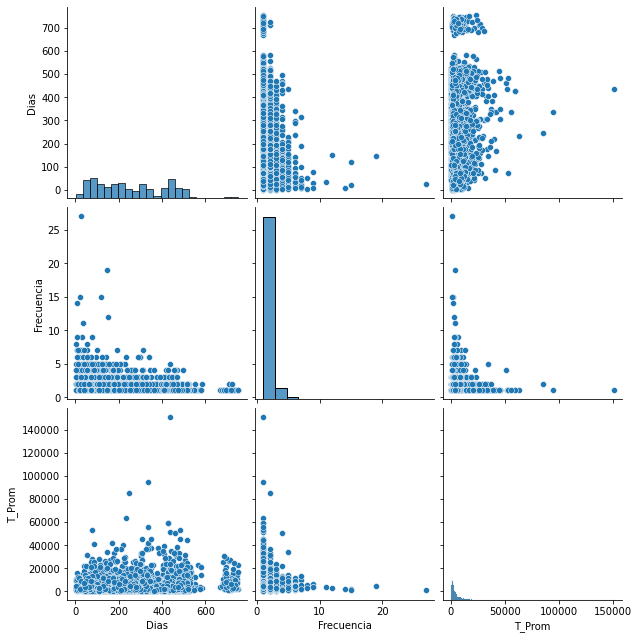

In [30]:
sb.pairplot(base,height=3,vars=['Dias','Frecuencia','T_Prom'],kind ='scatter')
plt.show()

## Comienza K- means

In [31]:
A = np.array(base[['R_class','F_class','TP_class']])
A.shape

(6432, 3)

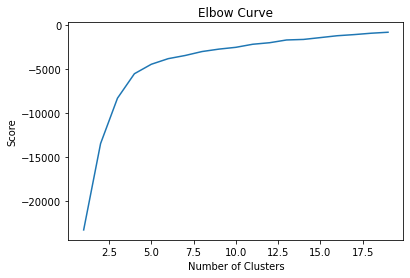

In [32]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(A).score(A) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [33]:
kmeans = KMeans(n_clusters=4).fit(A)
centroids = kmeans.cluster_centers_
print(centroids)

[[3.95288326 1.15682138 3.51898734]
 [2.08630394 1.03377111 1.31378987]
 [1.45823195 1.02189781 3.64882401]
 [4.53009119 1.14589666 1.35927052]]


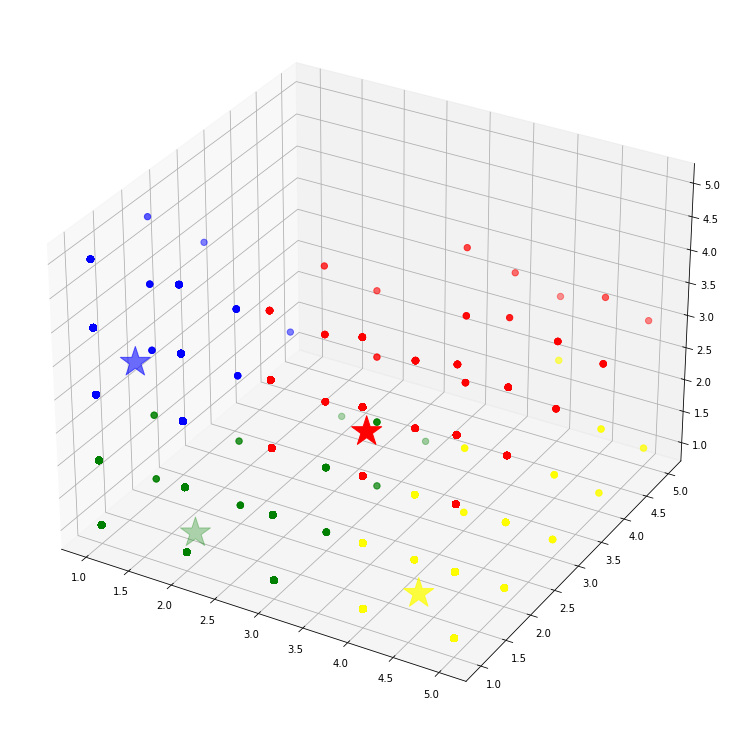

In [34]:
# Predicting the clusters
labels = kmeans.predict(A)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue','yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure(figsize=(20,10))
ax = Axes3D(fig)
ax.scatter(A[:, 0], A[:, 1], A[:, 2], c=asignar,s=40)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)
plt.show()

In [35]:
copia =  pd.DataFrame()
copia['email']=base['email'].values
#copy['categoria']=dataframe['categoria'].values
copia['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copia.groupby('label').size()
cantidadGrupo

color  cantidad
0     red      1422
1   green      2132
2    blue      1233
3  yellow      1645

In [36]:
copia

email  label
0     _ocamon12@hotmail.com      2
1          004609@sg.edi.mx      3
2         0194378@up.edu.mx      3
3      02105erick@gmail.com      0
4         0236077@up.com.mx      1
...                     ...    ...
6427     zuqui007@gmail.com      1
6428      zuralta@gmail.com      2
6429   zurdoek669@gmail.com      0
6430  zzepeda34@hotmail.com      2
6431      zzrob64@gamil.com      0

[6432 rows x 2 columns]

In [37]:
RFM=pd.merge(base,copia,on='email')

In [38]:
RFM

hs_object_id                  email   Fecha_Max   Importe  Frecuencia  \
0        66189657  _ocamon12@hotmail.com  2020-09-16   7423.28           1   
1       216899701       004609@sg.edi.mx  2021-10-13   2146.55           1   
2       208043201      0194378@up.edu.mx  2021-09-07   1805.17           1   
3       218042251   02105erick@gmail.com  2021-10-18   5423.28           1   
4       174533255      0236077@up.com.mx  2021-06-19    422.41           1   
...           ...                    ...         ...       ...         ...   
6427    101325986     zuqui007@gmail.com  2020-12-10   2230.17           1   
6428     79973132      zuralta@gmail.com  2020-10-22   3961.21           1   
6429    198695401   zurdoek669@gmail.com  2021-08-25  25516.37           3   
6430     77111704  zzepeda34@hotmail.com  2020-10-07   3786.21           1   
6431    159583201      zzrob64@gamil.com  2021-05-16   4236.20           1   

           T_Prom  Dias  F_class  R_class  TP_class  label  
0     7423.280000   496      1.0      1.0       4.0      2  
1     2146.550000   104      1.0      4.0       1.0      3  
2     1805.170000   140      1.0      4.0       1.0      3  
3     5423.280000    99      1.0      4.0       3.0      0  
4      422.410000   220      1.0      3.0       1.0      1  
...           ...   ...      ...      ...       ...    ...  
6427  2230.170000   411      1.0      2.0       1.0      1  
6428  3961.210000   460      1.0      1.0       3.0      2  
6429  8505.456667   153      2.0      4.0       4.0      0  
6430  3786.210000   475      1.0      1.0       3.0      2  
6431  4236.200000   254      1.0      3.0       3.0      0  

[6432 rows x 11 columns]

In [39]:
RFM.to_excel('HL-Ene2020Ene2022-ClustersRFM.xlsx',index=False,encoding='utf-8-sig') 